In [1]:
import sys
sys.path.append('./')
sys.path.append('../')

from authorship_identification import datasets
from authorship_identification import idf_utils
from authorship_identification import linear_models

import heapq
import warnings
import numpy as np
import pandas as pd
from scipy import sparse
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

random_seed = 42
np.random.seed = 42

/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
data_dir = 'All the News' # C50/All the News

### Load C50 Dataset

- this (original dataset) is 50 train - 50 test split

In [ ]:
test_frac = 0.5
train_df, test_df = datasets.get_C50(orig_split=True, split=None, remove_entities=False, seed=random_seed)

- this dataset is the original one with entity names removed

In [ ]:
test_frac = 0.5
train_df, test_df = datasets.get_C50(orig_split=True, split=None, remove_entities=True, seed=random_seed)

- this is 90 train - 10 test split

In [ ]:
test_frac = 0.1
train_df = pd.concat([train_df, test_df])
test_df = train_df.sample(frac=test_frac, random_state=random_seed)
train_df = train_df.drop(test_df.index)

### Load "All the News" 1 Dataset

- this (original) dataset is 85 train - 15 test split

In [ ]:
test_frac = 0.15
train_df, test_df = datasets.get_AllTheNews(orig_split=True, split=None, remove_entities=False, seed=random_seed)

- this dataset is the original one with entity names removed

In [2]:
test_frac = 0.15
train_df, test_df = datasets.get_AllTheNews(orig_split=True, split=None, remove_entities=True, seed=random_seed)

In [3]:
train_df.head()

,text,label
0,released a statement via email in which she sa...,0
1,Former and current congressional candidate bel...,0
2,On was suspended for after bringing an empt...,0
3,presidential hopeful used to release a new ad ...,0
4,"The ’s and , held in , , produced a “economi...",0


### Preprocessing

In [4]:
tfidf_args = idf_utils.tfidf_default_args
train_tfidf = idf_utils.idf_corpus(train_df, tfidf_args)
train_tfidf.head(10)

,word,idf
511618,김태미 etammykim,8.661762
307157,neighbor around,8.661762
307168,neighbor using,8.661762
307167,neighbor then,8.661762
307166,neighbor telling,8.661762
307165,neighbor says,8.661762
307164,neighbor saw,8.661762
307162,neighbor reportedly,8.661762
307161,neighbor in,8.661762
307160,neighbor https,8.661762


### From 11/03 Discussion: Remove Top-k IDF Words from documents

In [5]:
def train(train_df, test_df, train_idfdf, tfidf_args, idf_threshold):
    words, X_train, y_train, X_test, y_test = idf_utils.df_to_tfidf(
        train_df, test_df, train_idfdf, tfidf_args, idf_threshold=idf_threshold
    )

    acc_nb, f1_nb, feat_nb = linear_models.train_eval_nb(
        X_train, y_train, X_test, y_test
    )
    acc_sgd, f1_sgd, feat_sgd = linear_models.train_eval_sgd(
        X_train, y_train, X_test, y_test
    )

    return (words, X_train, y_train, X_test, y_test), feat_nb, feat_sgd, (acc_nb, f1_nb), (acc_sgd, f1_sgd)

In [6]:
# run this only once for testing/visualization
(words, X_train, y_train, X_test, y_test), feat_nb, feat_sgd, (acc_nb, f1_nb), (acc_lr, f1_lr) = train(
    train_df, test_df, train_tfidf, tfidf_args, idf_threshold=3.)
feat_names = words

/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['And', 'As', 'But', 'Follow', 'He', 'If', 'In', 'It', 'On', 'President', 'She', 'So', 'That', 'The', 'There', 'They', 'This', 'Trump', 'Twitter', 'We', 'What', 'You', 'about', 'according', 'added', 'after', 'against', 'all', 'also', 'an', 'and', 'any', 'are', 'around', 'as', 'asked', 'at', 'back', 'be', 'because', 'been', 'before', 'being', 'both', 'but', 'by', 'called', 'campaign', 'can', 'candidate', 'come', 'could', 'country', 'did', 'didn', 'do', 'does', 'doesn', 'don', 'down', 'during', 'election', 'even', 'fact', 'for', 'former', 'from', 'get', 'go', 'going', 'good', 'got', 'government', 'had', 'has', 'have', 'he', 'her', 'here', 'him', 'his', 'host', 'how', 'if', 'in', 'including', 'interview', 'into', 'is', 'it', 'its', 'just', 'know', 'like', 'lot', 'made', 'make', 

### 1. Naive Bayes Classifier

In [7]:
feat_df_nb = pd.DataFrame(feat_names, columns=['word'])
for i in range(feat_nb.shape[0]):
    feat_df_nb[i] = feat_nb[i,:]
feat_df_nb.head()

,word,0,1,2,3,4,5,6,7,8,9
0,And,0.000208,0.000102,0.000142,0.000096,0.000157,0.000482,0.000182,0.000227,0.000233,0.000381
1,And And,0.000031,0.000032,0.000032,0.000031,0.000032,0.000031,0.000033,0.000030,0.000029,0.000035
2,And But,0.000031,0.000032,0.000032,0.000031,0.000033,0.000031,0.000031,0.000030,0.000029,0.000031
3,And He,0.000031,0.000032,0.000032,0.000031,0.000031,0.000031,0.000031,0.000030,0.000029,0.000031
4,And If,0.000031,0.000032,0.000032,0.000031,0.000031,0.000034,0.000031,0.000030,0.000029,0.000033


### 2. SGD Classifier

In [8]:
feat_df_sgd = pd.DataFrame(feat_names, columns=['word'])
for i in range(feat_sgd.shape[0]):
    feat_df_sgd[i] = feat_sgd[i,:]
feat_df_sgd.head()

,word,0,1,2,3,4,5,6,7,8,9
0,And,2.266304,-13.749733,1.857348,-1.122119e+01,-0.633362,14.910369,-0.948506,7.214563,-1.341413e+01,6.736418
1,And And,-0.010788,-0.082422,-0.126680,-8.987924e-01,0.892180,-0.197470,0.667075,-0.651771,-2.408765e-03,0.501013
2,And But,-0.001379,-0.000079,-0.128009,-1.884135e-02,0.969787,-0.000236,-0.931074,-0.002611,-7.951821e-07,-0.157446
3,And He,-0.000003,-0.000015,0.236077,-1.187024e-08,-0.000001,-0.000026,-0.000019,-0.000003,-8.821914e-04,-0.000155
4,And If,-0.002299,-0.002743,-0.011875,-6.941313e-02,-0.127776,0.246185,-0.211197,-0.005757,-3.249059e-04,0.194232


### Evaluate

In [9]:
print('acc_nb: {:.4f}, f1_nb: {:.4f}'.format(acc_nb, f1_nb))
print('acc_lr: {:.4f}, f1_lr: {:.4f}'.format(acc_lr, f1_lr))

acc_nb: 0.3627, f1_nb: 0.3627
acc_lr: 0.8040, f1_lr: 0.8040


### Grid Search in Removing Top-k IDF Words vs. Performances

In [10]:
def grid_search_idf(threshold_list, nb_path, lr_path):
    
    index_list = []
    nb_train_accs, nb_test_accs, nb_train_f1s, nb_test_f1s = [], [], [], []
    lr_train_accs, lr_test_accs, lr_train_f1s, lr_test_f1s = [], [], [], []
    
    nb_clf = MultinomialNB()
    lr_clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.000001, n_iter_no_change=5, shuffle=True, random_state=random_seed)
    
    for threshold in threshold_list:
        
        print('>= IDF value of {:.2f} removed'.format(threshold))
        words, X_train, y_train, X_test, y_test = idf_utils.df_to_tfidf(
            train_df, test_df, train_tfidf, tfidf_args, idf_threshold=threshold
        )
        nb_clf.fit(X_train, y_train)
        lr_clf.fit(X_train, y_train)
        y_nb_train = nb_clf.predict(X_train)
        y_lr_train = lr_clf.predict(X_train)
        y_nb_test = nb_clf.predict(X_test)
        y_lr_test = lr_clf.predict(X_test)
        nb_train_acc, nb_train_f1 = eval_all(y_train, y_nb_train)
        lr_train_acc, lr_train_f1 = eval_all(y_train, y_lr_train)
        nb_test_acc, nb_test_f1 = eval_all(y_test, y_nb_test)
        lr_test_acc, lr_test_f1 = eval_all(y_test, y_lr_test)
        
        index_list.append(threshold)
        nb_train_accs.append(nb_train_acc)
        nb_test_accs.append(nb_test_acc)
        nb_train_f1s.append(nb_train_f1)
        nb_test_f1s.append(nb_test_f1)
        lr_train_accs.append(lr_train_acc)
        lr_test_accs.append(lr_test_acc)
        lr_train_f1s.append(lr_train_f1)
        lr_test_f1s.append(lr_test_f1)
    
    nb_df = pd.DataFrame(index_list, columns=['idf_threshold'])
    nb_df['train_accs'] = nb_train_accs
    nb_df['train_f1s'] = nb_train_f1s
    nb_df['test_accs'] = nb_test_accs
    nb_df['test_f1s'] = nb_test_f1s
    nb_df['model_name'] = 'nb'
    nb_df.to_csv(nb_path + '.csv', index=False)
    
    lr_df = pd.DataFrame(index_list, columns=['idf_threshold'])
    lr_df['train_accs'] = lr_train_accs
    lr_df['train_f1s'] = lr_train_f1s
    lr_df['test_accs'] = lr_test_accs
    lr_df['test_f1s'] = lr_test_f1s
    lr_df['model_name'] = 'lr'
    lr_df.to_csv(lr_path + '.csv', index=False)
    return (nb_train_accs, nb_train_f1s, nb_test_accs, nb_test_f1s), (lr_train_accs, lr_train_f1s, lr_test_accs, lr_test_f1s)

def eval_all(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print('accuracy:', accuracy, '   precision:', precision, '   recall:', recall, '   f1_macro:', f1_macro)
    return accuracy, f1_macro

def plot_idf(nb_path, lr_path, bert_path):
    nb_df = pd.read_csv(nb_path + '.csv')
    lr_df = pd.read_csv(lr_path + '.csv')
    bert_df = pd.read_csv(bert_path + '.csv')
    threshold_list = nb_df['idf_threshold']
    metric_ls = [('nb', nb_df['train_accs'], nb_df['test_accs'], nb_df['train_f1s'], nb_df['test_f1s']), 
                 ('lr', lr_df['train_accs'], lr_df['test_accs'], lr_df['train_f1s'], lr_df['test_f1s']),
                 ('bert', bert_df['train_accs'], bert_df['test_accs'], bert_df['train_f1s'], bert_df['test_f1s'])]
    category_colors = plt.get_cmap('brg')(np.linspace(0., 1., len(metric_ls)))
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    plt.xticks(rotation=0)
    axs.flatten()
    xrange = range(len(threshold_list))
    for (metric_name, train_acc, test_acc, train_f1, test_f1), color in zip(metric_ls, category_colors):
        axs[0].set_xticklabels(threshold_list)
        axs[0].set_xticks(xrange)
        axs[0].plot(xrange, train_acc, 'o--', color=color)
        axs[0].plot(xrange, test_acc, 'o-', color=color, label=metric_name + ' accuracy')
        axs[0].set_xlabel('IDF threshold')
        axs[0].set_ylabel('accuracy')
        axs[0].grid(axis='x', color='0.75')
        axs[0].legend()
        
        axs[1].set_xticklabels(threshold_list)
        axs[1].set_xticks(xrange)
        axs[1].plot(xrange, train_f1, 'o--', color=color)
        axs[1].plot(xrange, test_f1, 'o-', color=color, label=metric_name + ' F1 score')
        axs[1].set_xlabel('IDF threshold')
        axs[1].set_ylabel('F1 score')
        axs[1].grid(axis='x', color='0.75')
        axs[1].legend()
    plt.show()

In [12]:
grid_search_idf(threshold_list=np.arange(10., 1., -0.5), 
                nb_path='../result/' + data_dir + '/nb', lr_path='../result/' + data_dir + '/lr')

>= IDF value of 10.00 removed
accuracy: 0.7731764705882352    precision: 0.9251587708147975    recall: 0.7731693730422344    f1_macro: 0.8093360199327078
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.44666666666666666    precision: 0.8317712102615797    recall: 0.43870587597833255    f1_macro: 0.4474098400090144
accuracy: 0.8893333333333333    precision: 0.8866167737058511    recall: 0.8903637000178813    f1_macro: 0.8854185955417908
>= IDF value of 9.50 removed
accuracy: 0.7731764705882352    precision: 0.9251587708147975    recall: 0.7731693730422344    f1_macro: 0.8093360199327078
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.44666666666666666    precision: 0.8317712102615797    recall: 0.43870587597833255    f1_macro: 0.4474098400090144
accuracy: 0.8893333333333333    precision: 0.8866167737058511    recall: 0.8903637000178813    f1_macro: 0.8854185955417908
>= IDF value of 9.00 removed
accuracy: 0.7731764705882352    prec

/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '00pm', '01', '02', '03', '04', '04pm', '05', '05pm', '06', '07', '08', '09', '10', '100', '101', '10PM', '11', '1182', '12', '13', '14', '14pm', '15', '16', '17', '17pm', '18', '19', '19am', '1capplegate', '1st', '20', '2000', '2004', '2014', '2015', '2016', '21', '22', '23', '2334', '24', '25', '26', '27', '27pm', '28', '29', '30', '30s', '31', '32', '33', '33pm', '34', '35', '350', '35pm', '36', '360', '365', '37', '38', '39', '40', '405', '41', '42', '43', '44', '45', '45am', '46', '47', '48', '49', '49ers', '50', '500', '50pm', '51', '52', '53', '54', '55', '56', '57', '58', '59', '59pm', '656', '75', '88th', '90', '900', '93', '94', '97', '99', '9AM', 'A2020', 'AA', 'AB', 'ABC', 'ABC15', 'ABC7', 'ABCLiz', 'ABCNetwork', 'ABCPolitics', 'ABFalecbaldwin', 'ABF

accuracy: 0.7696470588235295    precision: 0.9245631396078077    recall: 0.7696886382620396    f1_macro: 0.80627806289436
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.44666666666666666    precision: 0.8251022772328367    recall: 0.4385276728769261    f1_macro: 0.4479528110142163
accuracy: 0.8893333333333333    precision: 0.8865315405621056    recall: 0.8907110933877804    f1_macro: 0.8856018174222576
>= IDF value of 8.00 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '101', '10PM', '11', '1182', '12', '13', '14', '15', '16', '17', '18', '19', '1st', '20', '2004', '2014', '2016', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '30s', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '49ers', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '75', '88th', '900', '94', '9AM', 'A2020', 'ABC', 'ABC15', 'ABC7', 'ABCLiz', 'ABCPolitics', 'ABFalecbaldwin', 'ABFoundation', 'AFP', 'AGAINST', 'AIDS', 'AIPAC', 'ALL', 'AM', 'AMAZING', 'AMERICA', 'AMPAS', 'AND', 'ANY', 'AP', 'AR', 'ASAP', 'ASwoyer', 'AT', 'ATF', 'AZ', 'AaronBlake', 'Abortion', 'About', 'Above', 'Absolutely', 'Academy', 'Ac

accuracy: 0.7656470588235295    precision: 0.9241562208741977    recall: 0.7656821555898696    f1_macro: 0.802908013593927
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.4493333333333333    precision: 0.8319699458819987    recall: 0.4410989142788259    f1_macro: 0.44953741616274445
accuracy: 0.8906666666666667    precision: 0.8878782810795464    recall: 0.8918633242578211    f1_macro: 0.8871447275227606
>= IDF value of 7.50 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1st', '20', '2016', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '48', '49', '49ers', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '900', '9AM', 'ABC', 'ABCLiz', 'ABCPolitics', 'AFP', 'AIPAC', 'ALL', 'AM', 'AMPAS', 'AND', 'ANY', 'AP', 'ATF', 'About', 'Absolutely', 'Academy', 'According', 'Achievement', 'Act', 'Action', 'Actor', 'Actors', 'Actress', 'Actually', 'Adams', 'Additionally', 'Administration', 'Adviser', 'Advisor', 'After', 'Again', 'Against', 'Age', 'Agent', 'Ahead', 'Ailes', 'Air', 'Aleppo', 'All', 'Allah', 'Allahu', 'Al

accuracy: 0.7508235294117647    precision: 0.9221863018555071    recall: 0.7508806271694215    f1_macro: 0.7901244108091487
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.448    precision: 0.8242776381896908    recall: 0.43990843808834973    f1_macro: 0.44776606689498755
accuracy: 0.8906666666666667    precision: 0.8881307886517954    recall: 0.8919516233550416    f1_macro: 0.8871551001919864
>= IDF value of 7.00 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '01', '02', '04', '05', '07', '08', '09', '10', '11', '12', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '29', '30', '32', '33', '35', '36', '37', '40', '41', '42', '43', '45', '48', '50', '51', '53', '55', '57', '58', '59', '9AM', 'ABC', 'ABCPolitics', 'AFP', 'ALL', 'AM', 'AND', 'About', 'Absolutely', 'Academy', 'According', 'Act', 'Action', 'Actor', 'Actors', 'Actress', 'Actually', 'Additionally', 'Administration', 'Adviser', 'Advisor', 'After', 'Again', 'Against', 'Agent', 'All', 'Allah', 'Along', 'Already', 'Also', 'Although', 'Am', 'Ambassador', 'Amendment', 'America', 'American', 'Among', 'An', 'Analyst', 'And', 'Another', 'Any', 'Anyone', 'Anything', 'Anyway', 'Apparently', 'Are', 'As', 'Ask', 'Asked', 'Assistant', '

accuracy: 0.7355294117647059    precision: 0.9200418087776109    recall: 0.7356026924590242    f1_macro: 0.7767215331501444
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.448    precision: 0.8340717329837857    recall: 0.4400642750710301    f1_macro: 0.44567718500354764
accuracy: 0.8946666666666667    precision: 0.8926238015727387    recall: 0.8960090212721875    f1_macro: 0.891547371313614
>= IDF value of 6.50 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '02', '05', '10', '11', '12', '15', '20', '22', '23', '25', '30', '33', '35', '40', '45', '50', '55', '9AM', 'ABC', 'AM', 'About', 'Absolutely', 'Academy', 'According', 'Act', 'Action', 'Actor', 'Actress', 'Actually', 'Additionally', 'Adviser', 'After', 'Again', 'All', 'Also', 'Although', 'Ambassador', 'Amendment', 'America', 'Among', 'An', 'And', 'Another', 'Any', 'Anyone', 'Apparently', 'Are', 'As', 'Asked', 'Assistant', 'At', 'Attorney', 'Authorities', 'Awards', 'BREAKING', 'Based', 'Be', 'Beast', 'Because', 'Before', 'Below', 'BernieSanders', 'Best', 'Big', 'Bill', 'Black', 'Both', 'But', 'By', 'CEO', 'CNN', 'Campaign', 'Can', 'Captain', 'Cash', 'Center', 'Chairman', 'Channel', 'Check', 'Chief', 'Clearly', 'Columnist', 'Come', 'Congressman', 'Conservative', 

accuracy: 0.7218823529411764    precision: 0.91947455759924    recall: 0.7220690848197072    f1_macro: 0.7650859930553502
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.44266666666666665    precision: 0.84454172101552    recall: 0.4343604450338705    f1_macro: 0.4415356510279234
accuracy: 0.896    precision: 0.8939585938554787    recall: 0.8976343211811807    f1_macro: 0.893111708853038
>= IDF value of 6.00 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '10', '11', '12', '15', '20', '25', '30', '9AM', 'About', 'According', 'Act', 'Actor', 'Actress', 'Adviser', 'After', 'Again', 'All', 'Also', 'Although', 'Ambassador', 'Amendment', 'America', 'Among', 'An', 'And', 'Another', 'Any', 'Are', 'As', 'Asked', 'At', 'Attorney', 'BREAKING', 'Be', 'Because', 'Before', 'Best', 'Big', 'Black', 'Both', 'But', 'By', 'CEO', 'CNN', 'Campaign', 'Can', 'Chairman', 'Channel', 'Chief', 'Congressman', 'Daily', 'Day', 'Deputy', 'Despite', 'Did', 'Director', 'Do', 'Does', 'Don', 'Dr', 'During', 'EST', 'Editor', 'Even', 'Every', 'Everybody', 'Everyone', 'Everything', 'Evil', 'Facebook', 'First', 'Follow', 'Following', 'For', 'Foreign', 'Former', 'From', 'General', 'Get', 'Given', 'Go', 'God', 'Good', 'Gov', 'Governor', 'Great', 'Gun',

accuracy: 0.6936470588235294    precision: 0.9171629455820216    recall: 0.6939533664269624    f1_macro: 0.7405341036767086
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.43466666666666665    precision: 0.8443837263602572    recall: 0.42572337577831376    f1_macro: 0.43252726401459807
accuracy: 0.896    precision: 0.8935638075506956    recall: 0.8965059802543939    f1_macro: 0.8929437322171732
>= IDF value of 5.50 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['000', '10', '9AM', 'About', 'According', 'Actor', 'After', 'Again', 'All', 'Also', 'Although', 'Ambassador', 'America', 'An', 'And', 'Another', 'Are', 'As', 'At', 'Attorney', 'Because', 'Before', 'Black', 'Both', 'But', 'By', 'CEO', 'Can', 'Chairman', 'Channel', 'Chief', 'Despite', 'Did', 'Director', 'Do', 'Does', 'Don', 'Dr', 'During', 'EST', 'Editor', 'Even', 'Every', 'Evil', 'Facebook', 'First', 'Follow', 'For', 'Former', 'From', 'General', 'God', 'Good', 'Gov', 'Governor', 'Great', 'Handle', 'Hard', 'He', 'Her', 'Here', 'Hey', 'His', 'How', 'However', 'If', 'In', 'Indeed', 'Inside', 'Instead', 'Internet', 'Is', 'It', 'Judge', 'Just', 'Justice', 'Lady', 'Later', 'Leader', 'Left', 'Let', 'Like', 'Listen', 'Listeners', 'Live', 'Lives', 'Look', 'Majority', 'Make', 'Many', '

accuracy: 0.6684705882352941    precision: 0.9135513410126501    recall: 0.6688910306665722    f1_macro: 0.7170501780172351
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.42533333333333334    precision: 0.8459361529837992    recall: 0.41578373784922984    f1_macro: 0.4164783763519071
accuracy: 0.888    precision: 0.8842962609695834    recall: 0.8880471187975708    f1_macro: 0.883621057006259
>= IDF value of 5.00 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['According', 'After', 'Again', 'All', 'Also', 'America', 'An', 'And', 'Another', 'As', 'At', 'Attorney', 'Because', 'Black', 'Both', 'But', 'By', 'CEO', 'Can', 'Chairman', 'Chief', 'Director', 'Do', 'Don', 'Dr', 'During', 'Even', 'Evil', 'Follow', 'For', 'Former', 'From', 'General', 'God', 'Gov', 'Governor', 'Handle', 'Hard', 'He', 'Her', 'Here', 'His', 'How', 'However', 'If', 'In', 'Inside', 'Instead', 'Internet', 'Is', 'It', 'Just', 'Leader', 'Left', 'Let', 'Like', 'Lives', 'Look', 'Many', 'Matter', 'Maybe', 'Minister', 'More', 'Mr', 'My', 'No', 'Not', 'Now', 'Of', 'Oh', 'On', 'Other', 'Our', 'Partial', 'People', 'Police', 'President', 'Prime', 'Reach', 'Read', 'Rep', 'Reporter', 'Revolution', 'Right', 'Secretary', 'See', 'Sen', 'Senator', 'Senior', 'She', 'SiriusXM', 'So'

accuracy: 0.6338823529411765    precision: 0.9030980816425064    recall: 0.6342584081998396    f1_macro: 0.6833012126888113
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.4093333333333333    precision: 0.8002940217540244    recall: 0.4010990664764266    f1_macro: 0.3978430053406291
accuracy: 0.8773333333333333    precision: 0.8729908790601657    recall: 0.8782911498338957    f1_macro: 0.8738808166931212
>= IDF value of 4.50 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['According', 'After', 'All', 'And', 'As', 'At', 'Attorney', 'Because', 'Black', 'But', 'By', 'CEO', 'Can', 'Director', 'Dr', 'During', 'Even', 'Evil', 'Follow', 'For', 'Former', 'From', 'General', 'God', 'Gov', 'Governor', 'Handle', 'Hard', 'He', 'Here', 'His', 'How', 'However', 'If', 'In', 'Inside', 'Is', 'It', 'Just', 'Left', 'Let', 'Look', 'Mr', 'My', 'No', 'Not', 'Now', 'Of', 'On', 'Our', 'People', 'President', 'Reach', 'Read', 'Rep', 'Revolution', 'Secretary', 'See', 'Sen', 'Senator', 'Senior', 'She', 'SiriusXM', 'So', 'Some', 'Speaker', 'State', 'Story', 'TV', 'That', 'The', 'There', 'These', 'They', 'This', 'Those', 'To', 'Trump', 'Twitter', 'Vice', 'We', 'Well', 'What', 'When', 'While', 'Why', 'With', 'Won', 'You', 'ability', 'able', 'about', 'above', 'absolutely', '

accuracy: 0.6028235294117648    precision: 0.900407758353943    recall: 0.6033624284849137    f1_macro: 0.6521961132148898
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.39466666666666667    precision: 0.7403066925089328    recall: 0.38645406711676894    f1_macro: 0.3721967254426314
accuracy: 0.8666666666666667    precision: 0.8631050554257931    recall: 0.8670474416343088    f1_macro: 0.8630454569406256
>= IDF value of 4.00 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['According', 'After', 'All', 'And', 'As', 'At', 'But', 'Can', 'During', 'Follow', 'For', 'From', 'He', 'His', 'How', 'However', 'If', 'In', 'It', 'Left', 'Let', 'Mr', 'My', 'No', 'Now', 'On', 'President', 'Reach', 'Secretary', 'See', 'Sen', 'Senator', 'Senior', 'She', 'SiriusXM', 'So', 'That', 'The', 'There', 'These', 'They', 'This', 'To', 'Trump', 'Twitter', 'We', 'Well', 'What', 'When', 'While', 'You', 'able', 'about', 'according', 'across', 'action', 'actually', 'added', 'adding', 'administration', 'after', 'again', 'against', 'ahead', 'airs', 'all', 'along', 'already', 'also', 'always', 'am', 'among', 'an', 'analyst', 'and', 'announced', 'another', 'any', 'anyone', 'anything', 'appeared', 'are', 'argued', 'around', 'as', 'ask', 'asked', 'at', 'attack', 'attacks', 'audien

accuracy: 0.5630588235294117    precision: 0.894172286367073    recall: 0.5633635217980764    f1_macro: 0.610813438801672
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.384    precision: 0.7787900672512451    recall: 0.376353177912507    f1_macro: 0.363925036480491
accuracy: 0.8546666666666667    precision: 0.850855972736308    recall: 0.8546349940532387    f1_macro: 0.8503193102224673
>= IDF value of 3.50 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['According', 'And', 'As', 'But', 'Follow', 'For', 'He', 'His', 'If', 'In', 'It', 'No', 'On', 'President', 'Reach', 'Secretary', 'Sen', 'Senior', 'She', 'So', 'That', 'The', 'There', 'They', 'This', 'Trump', 'Twitter', 'We', 'What', 'When', 'You', 'able', 'about', 'according', 'across', 'actually', 'added', 'administration', 'after', 'again', 'against', 'all', 'already', 'also', 'always', 'am', 'an', 'analyst', 'and', 'another', 'any', 'anything', 'are', 'around', 'as', 'asked', 'at', 'attack', 'available', 'away', 'back', 'be', 'because', 'become', 'been', 'before', 'behind', 'being', 'believe', 'best', 'better', 'between', 'big', 'book', 'both', 'broadcast', 'but', 'by', 'call', 'called', 'came', 'campaign', 'can', 'candidate', 'case', 'change', 'clear', 'columnist', 'com',

accuracy: 0.5421176470588235    precision: 0.8829649662892155    recall: 0.5423687496164943    f1_macro: 0.5851659355953756
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.37733333333333335    precision: 0.7369991968164726    recall: 0.36939019445020144    f1_macro: 0.3453272048608054
accuracy: 0.8466666666666667    precision: 0.8437532561513155    recall: 0.8476585628487474    f1_macro: 0.8438746801009638
>= IDF value of 3.00 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['And', 'As', 'But', 'Follow', 'He', 'If', 'In', 'It', 'On', 'President', 'She', 'So', 'That', 'The', 'There', 'They', 'This', 'Trump', 'Twitter', 'We', 'What', 'You', 'about', 'according', 'added', 'after', 'against', 'all', 'also', 'an', 'and', 'any', 'are', 'around', 'as', 'asked', 'at', 'back', 'be', 'because', 'been', 'before', 'being', 'both', 'but', 'by', 'called', 'campaign', 'can', 'candidate', 'come', 'could', 'country', 'did', 'didn', 'do', 'does', 'doesn', 'don', 'down', 'during', 'election', 'even', 'fact', 'for', 'former', 'from', 'get', 'go', 'going', 'good', 'got', 'government', 'had', 'has', 'have', 'he', 'her', 'here', 'him', 'his', 'host', 'how', 'if', 'in', 'including', 'interview', 'into', 'is', 'it', 'its', 'just', 'know', 'like', 'lot', 'made', 'make', 

accuracy: 0.532235294117647    precision: 0.8661185904698782    recall: 0.5318980245570304    f1_macro: 0.5736344481028366
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.3626666666666667    precision: 0.7227790778503498    recall: 0.35918372751470207    f1_macro: 0.35007632882882866
accuracy: 0.804    precision: 0.8035312998666511    recall: 0.804559767855222    f1_macro: 0.8003570818045228
>= IDF value of 2.50 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['And', 'But', 'Follow', 'He', 'In', 'It', 'President', 'That', 'The', 'This', 'Twitter', 'We', 'about', 'added', 'after', 'against', 'all', 'also', 'an', 'and', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'but', 'by', 'campaign', 'can', 'could', 'country', 'did', 'do', 'don', 'during', 'even', 'for', 'from', 'get', 'going', 'had', 'has', 'have', 'he', 'her', 'him', 'his', 'how', 'if', 'in', 'into', 'is', 'it', 'just', 'know', 'like', 'made', 'make', 'me', 'media', 'more', 'most', 'new', 'no', 'not', 'now', 'of', 'on', 'one', 'or', 'other', 'our', 'out', 'over', 'people', 'political', 'president', 'presidential', 're', 'said', 'say', 'she', 'should', 'so', 'some', 'than', 'that', 'the', 'their', 'them', 'there', 'they', 'think', 'this', 'time', 'to', 'told'

accuracy: 0.5967058823529412    precision: 0.8417211926107179    recall: 0.5959060168155144    f1_macro: 0.624040102661324
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.43466666666666665    precision: 0.713265679248414    recall: 0.43350940044396474    f1_macro: 0.42252939474060114
accuracy: 0.7546666666666667    precision: 0.7522953969178737    recall: 0.7575936549304348    f1_macro: 0.7500907267627059
>= IDF value of 2.00 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['He', 'It', 'The', 'Twitter', 'about', 'all', 'also', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'for', 'from', 'had', 'has', 'have', 'he', 'him', 'his', 'in', 'is', 'it', 'not', 'of', 'on', 'or', 'out', 'people', 'said', 'that', 'the', 'their', 'they', 'this', 'to', 'was', 'we', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'would', 'you'] not in stop_words.
  warnings.warn(


accuracy: 0.6983529411764706    precision: 0.7479761999955877    recall: 0.6974540435287478    f1_macro: 0.6919541711395987
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.5453333333333333    precision: 0.5587808298635163    recall: 0.5486748606084098    f1_macro: 0.5110223154087297
accuracy: 0.676    precision: 0.6733794228717324    recall: 0.6725782306151915    f1_macro: 0.6688615560720963
>= IDF value of 1.50 removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['The', 'and', 'as', 'at', 'be', 'by', 'for', 'from', 'have', 'he', 'in', 'is', 'it', 'not', 'of', 'on', 'said', 'that', 'the', 'to', 'was', 'with'] not in stop_words.
  warnings.warn(


accuracy: 0.5569411764705883    precision: 0.5641123898399594    recall: 0.55716076857851    f1_macro: 0.5519920227708986
accuracy: 0.804    precision: 0.8508835487656317    recall: 0.8046149209818078    f1_macro: 0.8063587096640653
accuracy: 0.48133333333333334    precision: 0.47001183438261956    recall: 0.47649212797803947    f1_macro: 0.46113189760783424
accuracy: 0.5546666666666666    precision: 0.5681417965583684    recall: 0.5473474643917218    f1_macro: 0.5388271703343875


(([0.7731764705882352,
   0.7731764705882352,
   0.7731764705882352,
   0.7696470588235295,
   0.7656470588235295,
   0.7508235294117647,
   0.7355294117647059,
   0.7218823529411764,
   0.6936470588235294,
   0.6684705882352941,
   0.6338823529411765,
   0.6028235294117648,
   0.5630588235294117,
   0.5421176470588235,
   0.532235294117647,
   0.5967058823529412,
   0.6983529411764706,
   0.5569411764705883],
  [0.8093360199327078,
   0.8093360199327078,
   0.8093360199327078,
   0.80627806289436,
   0.802908013593927,
   0.7901244108091487,
   0.7767215331501444,
   0.7650859930553502,
   0.7405341036767086,
   0.7170501780172351,
   0.6833012126888113,
   0.6521961132148898,
   0.610813438801672,
   0.5851659355953756,
   0.5736344481028366,
   0.624040102661324,
   0.6919541711395987,
   0.5519920227708986],
  [0.44666666666666666,
   0.44666666666666666,
   0.44666666666666666,
   0.44666666666666666,
   0.4493333333333333,
   0.448,
   0.448,
   0.44266666666666665,
   0.43466666

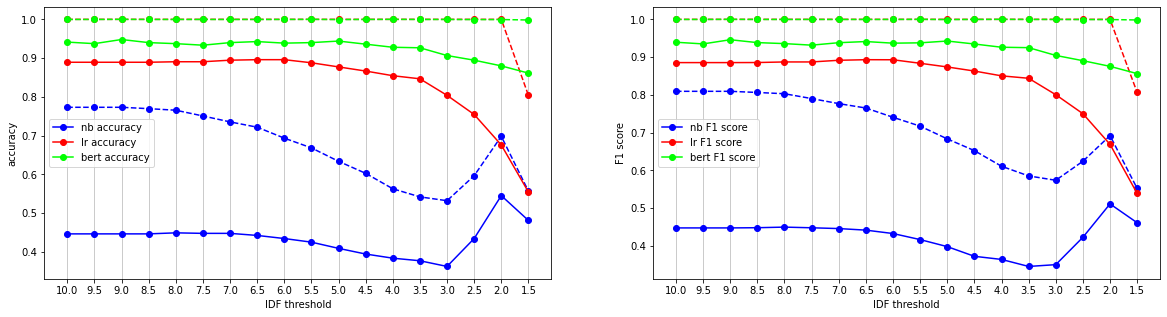

In [13]:
plot_idf(nb_path='../result/' + data_dir + '/nb', lr_path='../result/' + data_dir + '/lr', 
         bert_path='../result/' + data_dir + '/bert_uncased')

### Get TF-IDF Feat Values

In [14]:
def get_tfidf_feat(feat_df, feat_data, author_name, top_k=5, larger=True):
    idxs = feat_df.index[feat_df['label'] == author_name].tolist()
    feat_val = feat_data[idxs]
    word_val = feat_names
    n = feat_val.shape[0]
    word_array = []
    val_array = []
    for i in range(n):
        val_col = feat_val[i].toarray()[0]
        idxs = np.argsort(val_col)[-top_k:][::-1] if larger else np.argsort(val_col)[top_k:]
        words = word_val[idxs]
        vals = val_col[idxs]
        word_array.append(words)
        val_array.append(vals)
    word_array = np.array(word_array)
    val_array = np.array(val_array)
    sorted_idxs = np.argsort(-val_array.sum(axis=1))
    return word_array[sorted_idxs], val_array[sorted_idxs]

In [15]:
word_tfidf, val_tfidf = get_tfidf_feat(train_df, X_train, author_name=0, top_k=5)

### Feature Importance Extraction

In [16]:
def get_feat_importance(feat_df, word_col, author_cols, top_k=5, larger=True):
    n = feat_df.shape[0]
    word_array = []
    val_array = []
    for author_col in author_cols:
        val_col = feat_df[author_col].values.take
        idxs = heapq.nlargest(top_k, range(n), val_col) if larger else heapq.nsmallest(top_k, range(n), val_col)
        words = feat_df[word_col][idxs]
        vals = feat_df[author_col][idxs]
        word_array.append(words)
        val_array.append(vals)
    word_array = np.array(word_array)
    val_array = np.array(val_array)
    return word_array, val_array

In [17]:
n_classes = train_df['label'].nunique()
author_names = [i for i in range(n_classes)]
word_array_nb, val_array_nb = get_feat_importance(feat_df_nb, 'word', author_names, top_k=5)
word_array_sgd, val_array_sgd = get_feat_importance(feat_df_sgd, 'word', author_names, top_k=5)

### Feature Importance Visualization

In [18]:
def plot_feat_importance(word_array, val_array, author_cols, ycol_name):
    n, k = word_array.shape
    val_cum = val_array.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.25, 0.75, val_array.shape[1]))
    fig, ax = plt.subplots(figsize=(k*6, n//2))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(val_array, axis=1).max())
    for i, color in enumerate(category_colors):
        widthnames = word_array[:, i]
        widths = val_array[:, i]
        starts = val_cum[:, i] - widths
        ax.barh(author_cols, widths, left=starts, height=0.8, color=color)
        xcenters = starts + widths / 2
        for y, (x, name, val) in enumerate(zip(xcenters, widthnames, widths)):
            ax.text(x, y, name + ': ' + '{:.2f}'.format(val), ha='center', va='center', color='black')
    plt.ylabel(ycol_name)
    plt.title('top-' + str(k) + ' important word: importance values')
    plt.show()

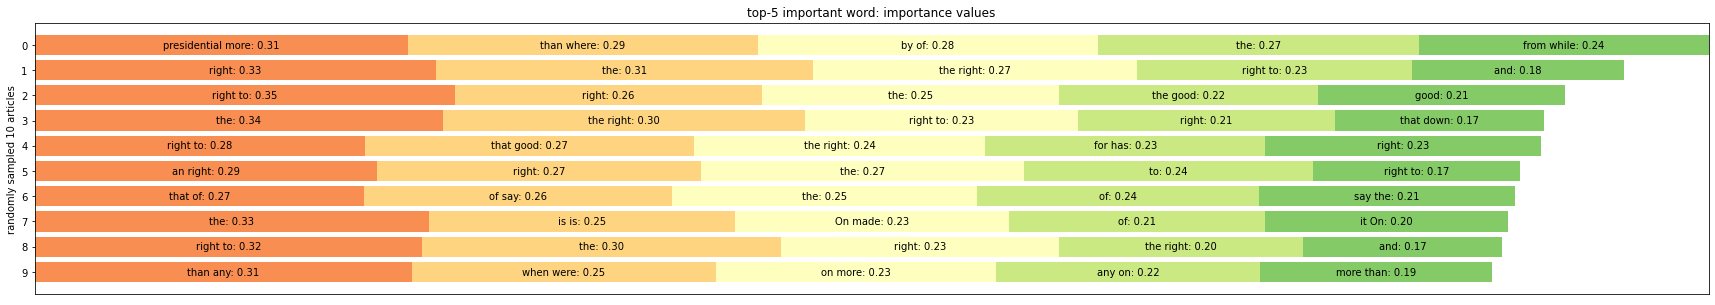

In [19]:
plot_feat_importance(word_tfidf[:10], val_tfidf[:10], [str(i) for i in range(10)], 'randomly sampled 10 articles')

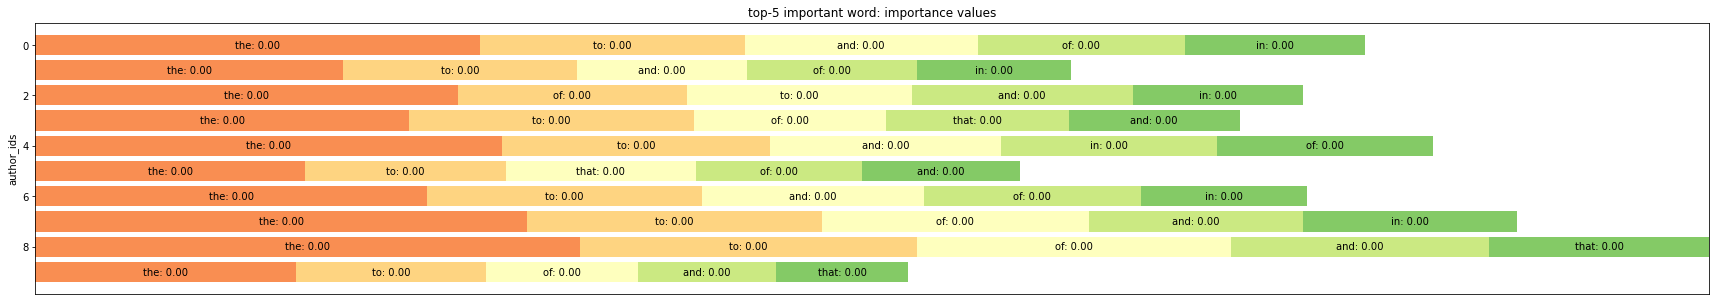

In [20]:
plot_feat_importance(word_array_nb[:10], val_array_nb[:10], author_names[:10], 'author_ids')

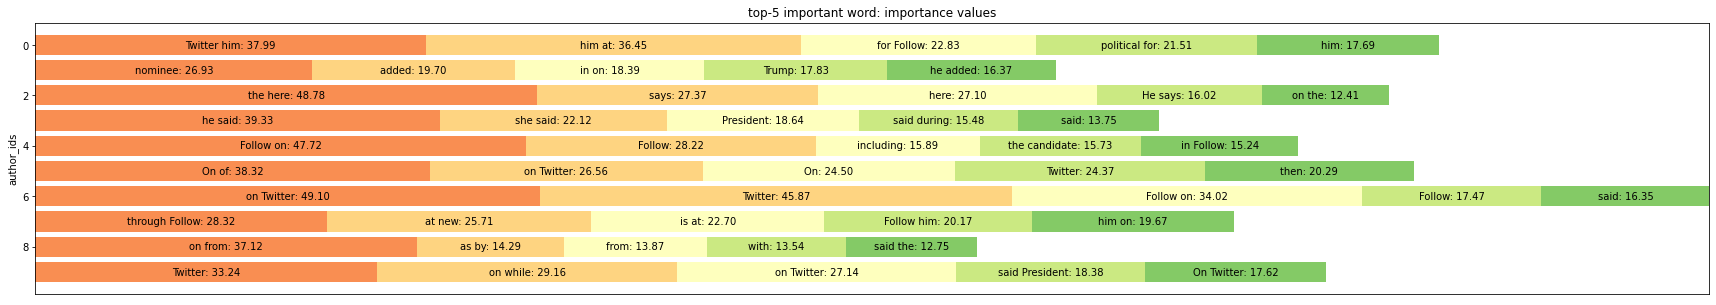

In [21]:
plot_feat_importance(word_array_sgd[:10], val_array_sgd[:10], author_names[:10], 'author_ids')